# Does Enhancing Images also Enhance the Outcome of Image Recognition of Neural Networks

# General Layout for this program

1. Imports
2. Load the training set
3. Load in the test set
4. Load in the test set labels
5. Create a copy of the image set and apply CLAHE to it
6. Load in 2 pretrained resnets
7. Train resnet1 on OG images, train resnet2 on CLAHE images
8. Compare performance of both

# Imports

In [13]:
import torch
from torchvision import *
import torch.nn as nn
import PIL.Image
import matplotlib.pyplot as plt
import os
from PIL import Image
from timeit import default_timer as timer
#import cv2
from torch.utils.data import Dataset, DataLoader

import pandas as pd
#from skimage import io, transform
#import helper
import time
import copy
import torch.optim as optim
from torch.optim import lr_scheduler


# Organize ImageNet so there are 50 images from each catagory in a test folder

-> All under imageNet/ILSVRC/Data/CLS-LOC/test

In [14]:
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

dataset = datasets.ImageFolder('./imageNet/ILSVRC/Data/CLS-LOC/train/', transform=transform)
trainLoader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

dataset = datasets.ImageFolder('./imageNet/ILSVRC/Data/CLS-LOC/test/', transform=transform)
testLoader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

Show example output

torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([3, 224, 224])
tensor(123)


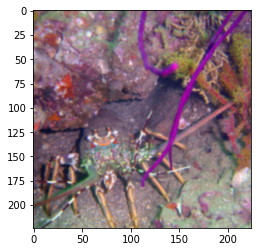

In [15]:
#images, labels = next(iter(trainLoader))
for images, labels in trainLoader:
    print(images.shape)
    print(labels.shape)
    break
image = images[0]
label = labels[0]
print(image.shape)
print(label)

plt.imshow(transforms.ToPILImage()(image), interpolation="bicubic")

## Train Model

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset_sizes = {'train': len(trainLoader.dataset), 'val': len(testLoader.dataset)}

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [17]:
#get the number of labels
num_labels = len(trainLoader.dataset.classes)
print (num_labels)

#get the number of classes
num_classes = len(testLoader.dataset.classes)
print (num_classes)

1001
218


In [24]:
def train_model(Trainloader, testLoader, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        #For the train phase
        phase = 'train'
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        #for inputs, labels in trainLoader:
        for i in range(0, len(Trainloader)):
            inputs, labels = next(iter(trainLoader))
            print(inputs.shape)
            print(labels.shape)

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                print(labels)
                print(outputs)
                print(outputs.shape)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        #Validation phase
        phase = 'val'
        model.eval()   # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in testLoader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                ans = torch.tensor(0)
                print("ans: ", ans)
                loss = criterion(outputs, ans)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [25]:
model_ft = train_model(trainLoader, testLoader, model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
torch.Size([32, 3, 224, 224])
torch.Size([32])
tensor([379,  88, 926, 521, 373, 534, 446, 432, 802, 406, 621,  43, 267, 114,
        114, 301, 745, 369, 151, 439, 544, 594, 285, 343, 142, 995,  87,  31,
        280, 425, 945, 266])
tensor([[-0.0716,  0.1173],
        [-0.7292, -0.2441],
        [ 0.0896,  0.7541],
        [-0.1164,  0.3171],
        [-0.1523, -0.1620],
        [ 0.0873,  0.3670],
        [-0.3144, -0.3504],
        [ 0.9317, -0.3158],
        [-0.5457,  0.2951],
        [ 0.0427,  0.7591],
        [ 0.0017,  0.6702],
        [-0.4339,  0.8379],
        [-0.0889,  0.7633],
        [-0.5534,  0.6032],
        [ 0.3675,  1.3144],
        [-0.5348,  0.1366],
        [ 0.5097,  0.1118],
        [-0.0927,  0.0436],
        [ 0.5301,  0.1730],
        [-0.3578, -0.1463],
        [-0.1018, -0.1588],
        [ 0.3896, -0.4126],
        [ 0.2324,  0.0336],
        [-0.4826,  0.1849],
        [ 0.9078,  0.4981],
        [-0.9541,  0.8033],
        [-0.0433, 

IndexError: Target 379 is out of bounds.

In [ ]:
import shutil

headDirectory = './imageNet/ILSVRC/Data/CLS-LOC/'

if os.path.isdir('./imageNet/ILSVRC/Data/CLS-LOC/' + 'test'):
    shutil.rmtree(headDirectory + 'test')

os.mkdir(headDirectory + 'test')

for folder in sorted(os.listdir(headDirectory + 'train')):

    if (folder == 'sals' or folder == '.DS_Store'):
        continue

    f = os.path.join(headDirectory + 'train/', folder)
    os.mkdir(headDirectory + 'test/' + folder)
    counter = 0

    for file in sorted( os.listdir(f)):
        #print(file)
        if counter == 50:
            break
        else:
            shutil.copy(f + '/' + file, headDirectory + 'test/' + folder)
            counter += 1

KeyboardInterrupt: 

# Import the Spotted Salamander image set


Get the size fo the largest and smallest images in the spotted salamander set

In [ ]:
smallestHeight = 1000
smallestWidth = 1000
largestHeight = 0
largestWidth = 0
numImages = 0

directory = './imageNet/ILSVRC/Data/CLS-LOC/train/n01632458'

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        numImages += 1
        img = cv2.imread(f)

        if img.shape[0] < smallestHeight:
            smallestHeight = img.shape[0]
        if img.shape[1] < smallestWidth:
            smallestWidth = img.shape[1]
        if img.shape[0] > largestHeight:
            largestHeight = img.shape[0]
        if img.shape[1] > largestWidth:
            largestWidth = img.shape[1]

print("Number of Images: " + str(numImages))
# print('Smallest Height = ' + str(smallestHeight))
# print('Smallest Width = ' + str(smallestWidth))
# print('Largest Height = ' + str(largestHeight))
# print('Largest Width = ' + str(largestWidth))

Number of Images: 1150


# Load the images in

In [ ]:
import torchvision
import numpy
from torchvision import transforms

input_shape = (224, 224)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transforms = transforms.Compose(
[
   #transforms.ToTensor(),
   #transforms.Resize((smallestHeight, smallestWidth)),
   #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
   transforms.ToTensor(),
   transforms.Normalize(mean, std),
   transforms.Resize((smallestHeight, smallestWidth))
])

directory = 'imageNet/ILSVRC/Data/CLS-LOC/train'
train_dataset = torchvision.datasets.ImageFolder(directory, transforms)
num_classes = len(train_dataset.classes)
print('num classes = ', len(train_dataset.classes))
print(type(train_dataset.classes))

print(train_dataset.classes[0])

# Need to remove first 50 images from each class
#train_dataset = torch.utils.data.Subset(train_dataset, range(50, len(train_dataset)))


print('len = ', train_dataset.__len__())
#print('item = ', train_dataset.__getitem__(0))

#print(type(train_dataset))
#print(type([train_dataset[0]]))
#print(type([train_dataset[0][0]]))

num classes =  1001
<class 'list'>
n01440764
len =  1132059


In [ ]:
#Doesnt show images right now
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

Turn the loaded images into a dataloader datatype

In [ ]:
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print("hello world")

hello world


In [ ]:
print(train_loader)

In [ ]:
# Example of target with class indices
loss = nn.CrossEntropyLoss()
input1 = torch.randn(3, 5, requires_grad=True)
target1 = torch.empty(3, dtype=torch.long).random_(5)

print(input1)
print(target1)
output1 = loss(input, target1)
output1.backward()

# Example of target with class probabilities
input2 = torch.randn(3, 5, requires_grad=True)
target2 = torch.randn(3, 5).softmax(dim=1)
output2 = loss(input2, target2)
output2.backward()
print("success")

tensor([[ 0.5037,  1.5843,  0.1858, -0.9493, -0.1332],
        [ 1.0401,  0.8596, -0.7138, -0.5661, -2.9504],
        [-0.0099,  0.0994, -0.0810,  0.0785, -1.3774]], requires_grad=True)
tensor([0, 1, 2])


TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not method

Create the learning model

In [ ]:
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT, num_classes=num_classes - 1)

criterion = nn.CrossEntropyLoss()

print(resnet.parameters())

optimizer = optim.SGD(resnet.parameters(), lr=0.0001, momentum=0.9)

num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 128)
device = 'cpu'


<generator object Module.parameters at 0x1177ce270>


Train the model

In [ ]:
from cgitb import reset


n_epochs = 5
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)

resnet.train()

for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    batch_idx = -1
    for (data_, target_) in train_loader:
        batch_idx += 1

        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()

        outputs = resnet(data_)
        print("len targets", len(target_))
        print("len outputs", len(outputs))

        print("target_", target_)
        print("outputs", outputs)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t = 0
    correct_t = 0
    with torch.no_grad():
        resnet.eval()
        for data_t, target_t in (train_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = resnet(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(train_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(resnet.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    resnet.train()

Epoch 1

len targets 100
len outputs 100
target_ tensor([751, 925, 524, 242, 246, 150, 330, 916, 163, 719, 632, 102, 327, 109,
        854, 935, 861, 235, 396, 962, 309, 121, 944, 449, 714, 708, 617, 641,
        991, 680, 938, 758, 789, 607, 331, 356, 336, 228, 242, 333,  54, 318,
        297, 804, 365, 185, 406, 250,  18, 648, 642,   1,  42, 587, 532, 327,
         21, 818, 569, 185, 351, 728, 286, 443,  51, 109, 275, 989, 715, 507,
        804, 646, 281, 807, 890, 660, 701, 922, 163, 128, 173, 103, 275, 621,
        478, 211, 110, 926, 901, 199, 981, 989, 339, 496, 930, 452, 275, 372,
        280, 361])
outputs tensor([[-1.8942, -0.2458, -1.6469,  ...,  1.2026,  0.7494, -0.9222],
        [-0.2649,  0.3470, -0.8355,  ...,  0.1008,  0.7801, -1.1237],
        [ 0.1655, -0.7708, -1.8748,  ..., -0.7916,  0.5309, -0.7116],
        ...,
        [-0.5864, -0.3706, -1.8882,  ...,  0.4070,  1.0438, -0.7013],
        [-0.0880, -1.1864, -2.0761,  ...,  0.4144,  2.3641, -0.6381],
        [ 0.801

IndexError: Target 751 is out of bounds.

## Save model

In [ ]:
save_path = 'SalamanderResnet.pth'
torch.save(resnet.state_dict(), save_path)

# Switch into eval mode and test it on some images

In [ ]:
from cgi import test

resnet.eval()

testSet = []
directory = './imageNet/ILSVRC/Data/CLS-LOC/test'


#Load in all test salamader images
testData = torchvision.datasets.ImageFolder(directory, transforms)
testData = torch.utils.data.Subset(testData, range(50))

print(type(testData))
print(len(testData))

<class 'torch.utils.data.dataset.Subset'>
50


In [ ]:
#Switch Model into eval mode
resnet.eval()
test_loader = DataLoader(testData, batch_size=50, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
with torch.no_grad():
    running_loss = 0.
    running_corrects = 0
    for i, (inputs, labels) in enumerate(test_loader):
        print("label = ", labels)
        print("inputs = ", inputs)
        print("loop " + str(i))
        if (i == 50):
            break
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = resnet(inputs)
        print('outputs ', outputs )
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        if i == 0:
            print('======>RESULTS<======')
            #images = torchvision.utils.make_grid(inputs[:4])
    epoch_loss = running_loss / len(testData)
    epoch_acc = running_corrects / len(testData) * 100.
    print('[Test #{}] Loss: {:.4f} Acc: {:.4f}%'.
          format(epoch, epoch_loss, epoch_acc))

label =  tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])
inputs =  tensor([[[[0.5744, 0.3828, 0.2692,  ..., 0.1600, 0.0672, 0.5370],
          [0.4968, 0.3041, 0.2234,  ..., 0.0667, 0.0786, 0.3704],
          [0.5122, 0.2530, 0.4054,  ..., 0.1577, 0.1067, 0.1071],
          ...,
          [0.2044, 0.3462, 0.3323,  ..., 0.3689, 0.2107, 0.2716],
          [0.2433, 0.5014, 0.2148,  ..., 0.2467, 0.1235, 0.0477],
          [0.5387, 0.4669, 0.3714,  ..., 0.3030, 0.2539, 0.1776]],

         [[0.6834, 0.5164, 0.2964,  ..., 0.2198, 0.2356, 0.6205],
          [0.5812, 0.3899, 0.2398,  ..., 0.1474, 0.1986, 0.4012],
          [0.6164, 0.3831, 0.5370,  ..., 0.2269, 0.1961, 0.1569],
          ...,
          [0.3078, 0.4447, 0.4244,  ..., 0.4391, 0.3629, 0.4134],
          [0.3622, 0.5387, 0.2696,  ..., 0.4215, 0.2722, 0.5032],
          [0.6350, 0.5920, 0.4177,  ..., 0.3695,